In [1]:
#########################################################
####
#### Tutorial: RNA Design with Infrared (for Developers)
####
#########################################################

###############################################
## Start with simple sampling of RNA sequences

# -- _the_ main module of Infrared
import infrared as ir

In [2]:
# -- specify a constraint network and it's tree decomp

# our first CN is _very_ simple: 20 variables (=sequence positions), no dependencies
cn = ir.ConstraintNetwork(varnum=20, domains=4)
# produce cluster tree for the CN, using default tree decomposition
ct = ir.ClusterTree(cn)

tree width = 0
bags = [[7], [17], [6], [15], [12], [11], [9], [16], [0], [13], [14], [10], [1], [3], [4], [19], [18], [5], [8], [2]]
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19)]


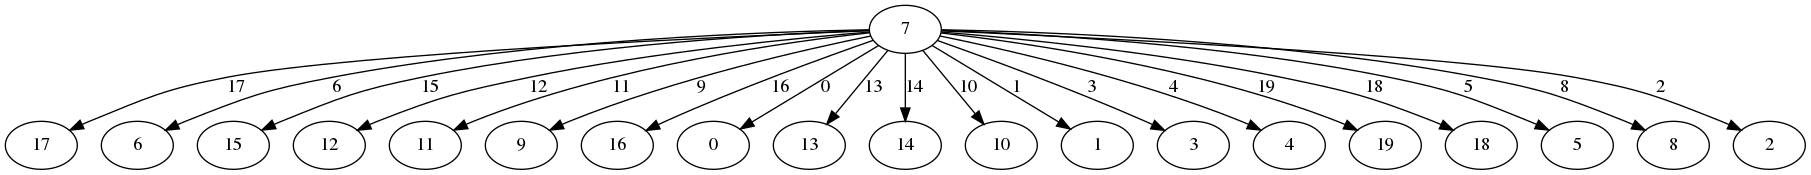

In [3]:
def show_td_info(ct,width):
    td = ct.get_td()
    print("tree width =", td.treewidth())
    print("bags =", td.get_bags())
    print("edges =", td.get_edges())
    
    tmpfile="tmp_out"
    td.writeTD(open(tmpfile+".dot","w"))
    import treedecomp
    treedecomp.dotfile_to_png(tmpfile+".dot")
    from IPython.display import Image
    return Image(filename=(tmpfile+".png"),width=width)
    
show_td_info(ct,500)

In [4]:
# -- evaluate the cluster tree
#   -- in this simple case, this will count the structures
count = ct.evaluate()
print("# =",int(count))
# btw, of course, 'count' is the number of all possible seqs 4**20

# = 1099511627776


In [5]:
# -- generate 10 samples
samples = [ct.sample().values() for i in range(10)]

In [6]:
samples

[[0, 2, 2, 3, 3, 2, 0, 1, 1, 0, 2, 3, 0, 2, 0, 1, 0, 0, 1, 2],
 [2, 1, 0, 2, 2, 3, 3, 3, 2, 1, 3, 3, 1, 3, 1, 1, 3, 3, 2, 1],
 [0, 0, 3, 1, 3, 0, 1, 0, 2, 3, 0, 3, 1, 0, 1, 2, 3, 3, 0, 2],
 [2, 1, 2, 2, 3, 0, 0, 2, 2, 1, 2, 3, 3, 1, 2, 1, 0, 3, 1, 3],
 [1, 1, 2, 3, 1, 2, 2, 1, 3, 3, 3, 3, 0, 3, 2, 3, 0, 1, 2, 3],
 [0, 2, 1, 1, 0, 1, 2, 2, 3, 1, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0],
 [0, 0, 1, 2, 0, 0, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 3, 2, 2, 0],
 [2, 0, 3, 0, 2, 3, 3, 2, 2, 0, 0, 0, 3, 3, 1, 0, 3, 0, 0, 0],
 [1, 0, 0, 0, 2, 0, 2, 3, 3, 2, 1, 1, 2, 3, 3, 0, 2, 3, 0, 3],
 [3, 3, 3, 2, 0, 3, 0, 1, 2, 3, 3, 3, 2, 3, 3, 1, 2, 3, 2, 2]]

In [7]:
# -- and show them (pretty)
from infrared import rna
[rna.values_to_sequence(s) for s in samples]

['AGGUUGACCAGUAGACAACG',
 'GCAGGUUUGCUUCUCCUUGC',
 'AAUCUACAGUAUCACGUUAG',
 'GCGGUAAGGCGUUCGCAUCU',
 'CCGUCGGCUUUUAUGUACGU',
 'AGCCACGGUCCUUUAUACCA',
 'AACGAAUGCAUGAGAAUGGA',
 'GAUAGUUGGAAAUUCAUAAA',
 'CAAAGAGUUGCCGUUAGUAU',
 'UUUGAUACGUUUGUUCGUGG']

In [8]:
##################################################
## add constraints from an RNA secondary structure
structure = "((((...))))(((...)))"
bps = rna.parseRNAStructureBps(structure)

In [9]:
bps

[(0, 10), (1, 9), (2, 8), (3, 7), (11, 19), (12, 18), (13, 17)]

In [10]:
complementary_nucleotides = ["AU","CG","GC","GU","UA","UG"]
# -- define complementarity constraints
class ComplConstraint(ir.Constraint):
    def __init__(self,i,j):
        super().__init__([i,j])
        self.i = i
        self.j = j
    def __call__(self,a): # a=assignment / sequence of nucleotides
        a = a.values()
        nucls = rna.values_to_sequence([a[self.i],a[self.j]])
        return nucls in complementary_nucleotides
    
## btw, there is already a pre-defined constraint rna.ComplConstraint,
## which we could have used as well

cons = [ ComplConstraint(i,j) for (i,j) in bps ]
deps = [ x.vars() for x in cons ]
cons, deps

([<__main__.ComplConstraint at 0x7f2f315a4f10>,
 [[0, 10], [1, 9], [2, 8], [3, 7], [11, 19], [12, 18], [13, 17]])

tree width = 1
bags = [[10, 0], [3], [3, 7], [18], [12, 18], [9], [9, 1], [13], [13, 17], [2], [8, 2], [11], [19, 11], [14], [4], [16], [6], [5], [15]]
edges = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 11), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12)]


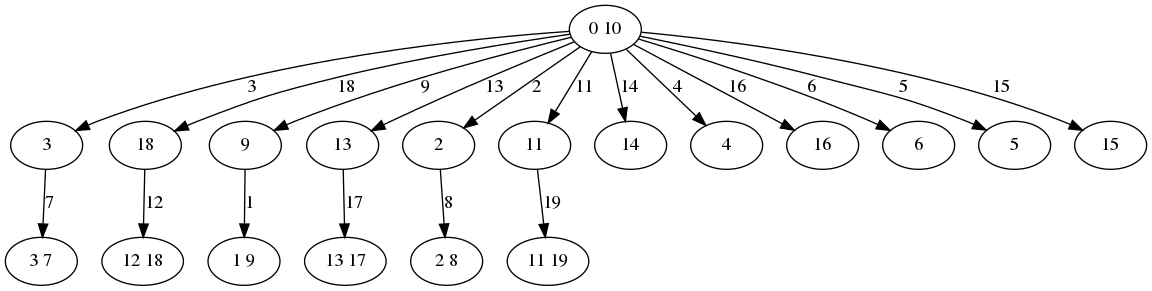

In [11]:
# -- reinitialize constraint network, rebuild tree decomp and cluster tree
#complementary_nucleotides = ["AU"]

seqlen = len(structure) # --> number of positions / variables in the CN
cn = ir.ConstraintNetwork(varnum=seqlen, domains=4, constraints = cons)
ct = ir.ClusterTree(cn)

show_td_info(ct,500)

In [12]:
# generate samples (with complementarity constraints)
def spit_them_samples_out(ct,num):
    samples = [ ct.sample().values() for i in range(num) ]
    return [ rna.values_to_sequence(s) for s in samples ]

count = ct.evaluate()
print("# =",int(count))
# btw, count == 6**7 * 4**6, by simple combinatorics

print("  "+structure)
spit_them_samples_out(ct,10)

# = 1146617856
  ((((...))))(((...)))


['UUCGAGAUGGGCAGGAGCUG',
 'AAGUCGUAUUUGCUUCCAGC',
 'GGGCGCGGUCUCGCCAGGUG',
 'AGGUAUGACCUGAUCCAAUU',
 'CGUUGUUGGCGUCUACUGGA',
 'UAGUUGAGCUGGCCCCCGGU',
 'CCGCCCAGUGGUUUCAAAGG',
 'ACGGCGCCCGUGGGAACUUU',
 'GUGACUCUUAUGAAGCAUUU',
 'UAAGACUUUUAUUCCAGGAA']

In [13]:
##########################
## Control the GC content

# -- define function for GC Control
class GCControl(ir.Function):
    def __init__(self,i,weight):
        super().__init__([i])
        self.i = i
        self.weight = weight
    def __call__(self,a):
        a = a.values()
        nucl = rna.value_to_nucleotide(a[self.i])
        if nucl in "GC":
            return self.weight
        else:
            return 1.0

## btw, there is predefined rna.GCControl

In [14]:
## -- setup functions
gc_weight = 1 ## <- try different weights: 0.1, 10, ...

gc_funs = [ GCControl(i,gc_weight) for i in range(seqlen) ]

# -- reinitialize constraint network, rebuild tree decomp and cluster tree
cn = ir.ConstraintNetwork(varnum=seqlen, domains=4,
                          constraints=cons,
                          functions=gc_funs)
ct = ir.ClusterTree(cn)

spit_them_samples_out(ct, 10)

['UCGUGGAGCGAAACGGCGUU',
 'AUGGUCACUGUUGGACUCCG',
 'CCAUGGAAUGGCCGUAGUGG',
 'UAGUGGGGCUACUGUUCUGG',
 'UUUGGAACAGACUAAAGUGG',
 'UGUGAUCUGUGAGGAGGUCU',
 'GUUUUGCGGGUGACUUUGUU',
 'GUUCUUAGGGUUGGUGCCUG',
 'ACUGCAGUGGUCCGUGCCGG',
 'UUUGAGAUGGGAUGGAAUGU']

In [15]:
##########################
## Control the BP energy

rna.set_bpenergy_table() # set bp energies to magic numbers

bpe_weight = 1 ## <- try different weights: 0.1, 10, ...
bpe_funs = [ rna.BPEnergy(i,j,False,bpe_weight) for (i,j) in bps ] 

cn = ir.ConstraintNetwork(varnum=seqlen, domains=4,
                          constraints=cons,
                          functions=bpe_funs + gc_funs)
ct = ir.ClusterTree(cn)


print("  "+structure)
spit_them_samples_out(ct, 10)

  ((((...))))(((...)))


['AGCUACUGGCUGGUUUCGUU',
 'GUCGGGACGGUAUCCUCGAU',
 'AGAGUUUCUUUCUUAGCGAG',
 'CGUCGUUGACGAUACACUGU',
 'GGAGGGACUCUCAUCUAGUG',
 'GCUUGAAGAGUUUAUGCUAG',
 'AUUAAAAUAAUUAGUGCCUA',
 'ACCCGUGGGGUCUCCUGGAG',
 'CGUUACCAAUGUUACGGUAG',
 'UUCGUUGCGAACUGGGAUGG']

In [16]:
### as example of additional hard constraints: avoid GG dinucleotides
class AvoidGGConstraint(ir.Constraint):
    def __init__(self,i):
        super().__init__([i,i+1])
        self.i = i
    def __call__(self,a): # a=assignment / sequence of nucleotides
        a = a.values()
        nucls = rna.values_to_sequence([a[self.i],a[self.i+1]])
        return nucls != "GG"

gg_cons = [ AvoidGGConstraint(i) for i in range(seqlen-1) ]

In [17]:
cn = ir.ConstraintNetwork(varnum=seqlen, domains=4,
                          constraints = cons + gg_cons,
                          functions = bpe_funs + gc_funs)
ct = ir.ClusterTree(cn)

print("  "+structure)
spit_them_samples_out(ct, 10)

  ((((...))))(((...)))


['GUUUUUAAGACACGCAACGU',
 'UCAGUUACUGAUUGUGCUAG',
 'GUGCGUAGCACGUUUUUAAU',
 'CGACAGCGUCGAUUAGCAGU',
 'UGAUCGCGUUAUUACUCUGA',
 'UUUGCGCUAGAGAUCGUGUC',
 'UAUAUAAUAUAGAGCGCUUC',
 'UUCGUAGUGAGUAGCCACUA',
 'ACACGCAGUGUGAUGUAGUU',
 'CGAUCGCGUUGUACGUCGUA']

In [18]:
#### now, automatize the targeting of feature values
##

# -- we start by defining the features

class GCFeature(ir.Feature):
    def __init__(self, weight, target, tolerance):
        super().__init__( "GC", weight, target, tolerance)
    def eval(self, sample):
        return rna.GC_content(sample) * 100

class EnergyFeature(ir.Feature):
    def __init__(self, structure, weight, target, tolerance):
        super().__init__( "E", weight, target, tolerance )
        self.structure = structure
    def eval(self, sample):
        import RNA
        return RNA.energy_of_struct(sample, self.structure)

In [19]:
# -- next, instantiate the sampler

class MySampler(ir.MultiDimensionalBoltzmannSampler):
    def __init__( self, features ):
        super().__init__(features)
        
    def gen_constraint_network(self, features):
        bpe_weight = features["E"].weight
        bpe_funs = [ rna.BPEnergy(i,j,False,bpe_weight) for (i,j) in bps ] 
        gc_weight = features["GC"].weight
        gc_funs = [ GCControl(i,gc_weight) for i in range(seqlen) ]
        return ir.ConstraintNetwork(varnum=seqlen, domains=4,
                                    constraints = cons,
                                    functions = bpe_funs + gc_funs)
    
    def sample(self):
        return rna.values_to_sequence(super().sample().values())
                  
# -- produce the feature objects 
# !!! here we define the targeted feature values and tolerances !!!
features = { "E": EnergyFeature(structure,1,-2,1),
             "GC": GCFeature(1,70,15) }

# -- from this, construct the sampler
sampler = MySampler(features)

In [20]:
# -- and sample away
count=0
for seq in sampler.targeted_samples():
    import RNA # for energy evaluation
    print("{} {:.2f} {:.2f}".format(seq, RNA.energy_of_struct(seq,structure), 100*rna.GC_content(seq)))
    count+=1
    if count >= 10:
        break

UGCUGCCGGCACGGACCCCG -2.50 80.00
GCUCGCCGAGCCUGUGUCAG -2.40 70.00
GGGGCGUCCCUUGCGGUGCA -2.70 75.00
CUCAAGCUGAGGUCCUUGAC -1.20 55.00
ACGAACUUCGUGGUAGUGCC -1.20 55.00
CGCGCCUCGCGGGUAGGACU -2.40 75.00
ACAUCGUGUGUGCCUAUGGC -1.30 55.00
CGGCUAUGCCGUUGGGCCAA -1.60 65.00
UGGUCGGACCAGCGUUGCGU -1.30 65.00
GGAUGGCGUCCCGGAGACCG -2.60 75.00
